In [1]:
import numpy as np
import pydicom
import cv2
from PIL import Image

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
inputList = glob('./train/dcm/*')
outputList = glob('./train/label/*')

inputList.sort()
outputList.sort()

len(inputList), len(outputList)

(100, 100)

In [3]:
def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def apply_window(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_width, window_level):
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = apply_window(image_hu.copy(), window_level, window_width)
    image_window_norm = resize_normalize(image_window)

    return image_window_norm

In [4]:
# preprocessing


# outputs = np.stack([np.array(Image.open(y)) for y in outputList] )
# print(inputs.shape, outputs.shape)

# add input layer
input1 = np.stack([read_dicom(path=x, window_width=500, window_level=255) for x in inputList])
input2 = np.stack([read_dicom(path=x, window_width=500, window_level=5) for x in inputList])
input3 = np.stack([read_dicom(path=x, window_width=5, window_level=255) for x in inputList])
# inputs = np.stack([input1, input2, input3], axis=1)
inputs = np.stack([input1, input2, input3], axis=1)

# add output layer
output0 = np.stack([np.array(Image.open(y)) for y in outputList])

output1 = np.where(output0==0, 4, 0)
output2 = np.where(output0==1, 3, 0)
output3 = np.where(output0==2, 2, 0)
output4 = np.where(output0==3, 1, 0)

outputs = np.stack([output1, output2, output3, output4], axis=1)


inputs.shape, outputs.shape

((100, 3, 512, 512), (100, 4, 512, 512))


Displaying frames for examples


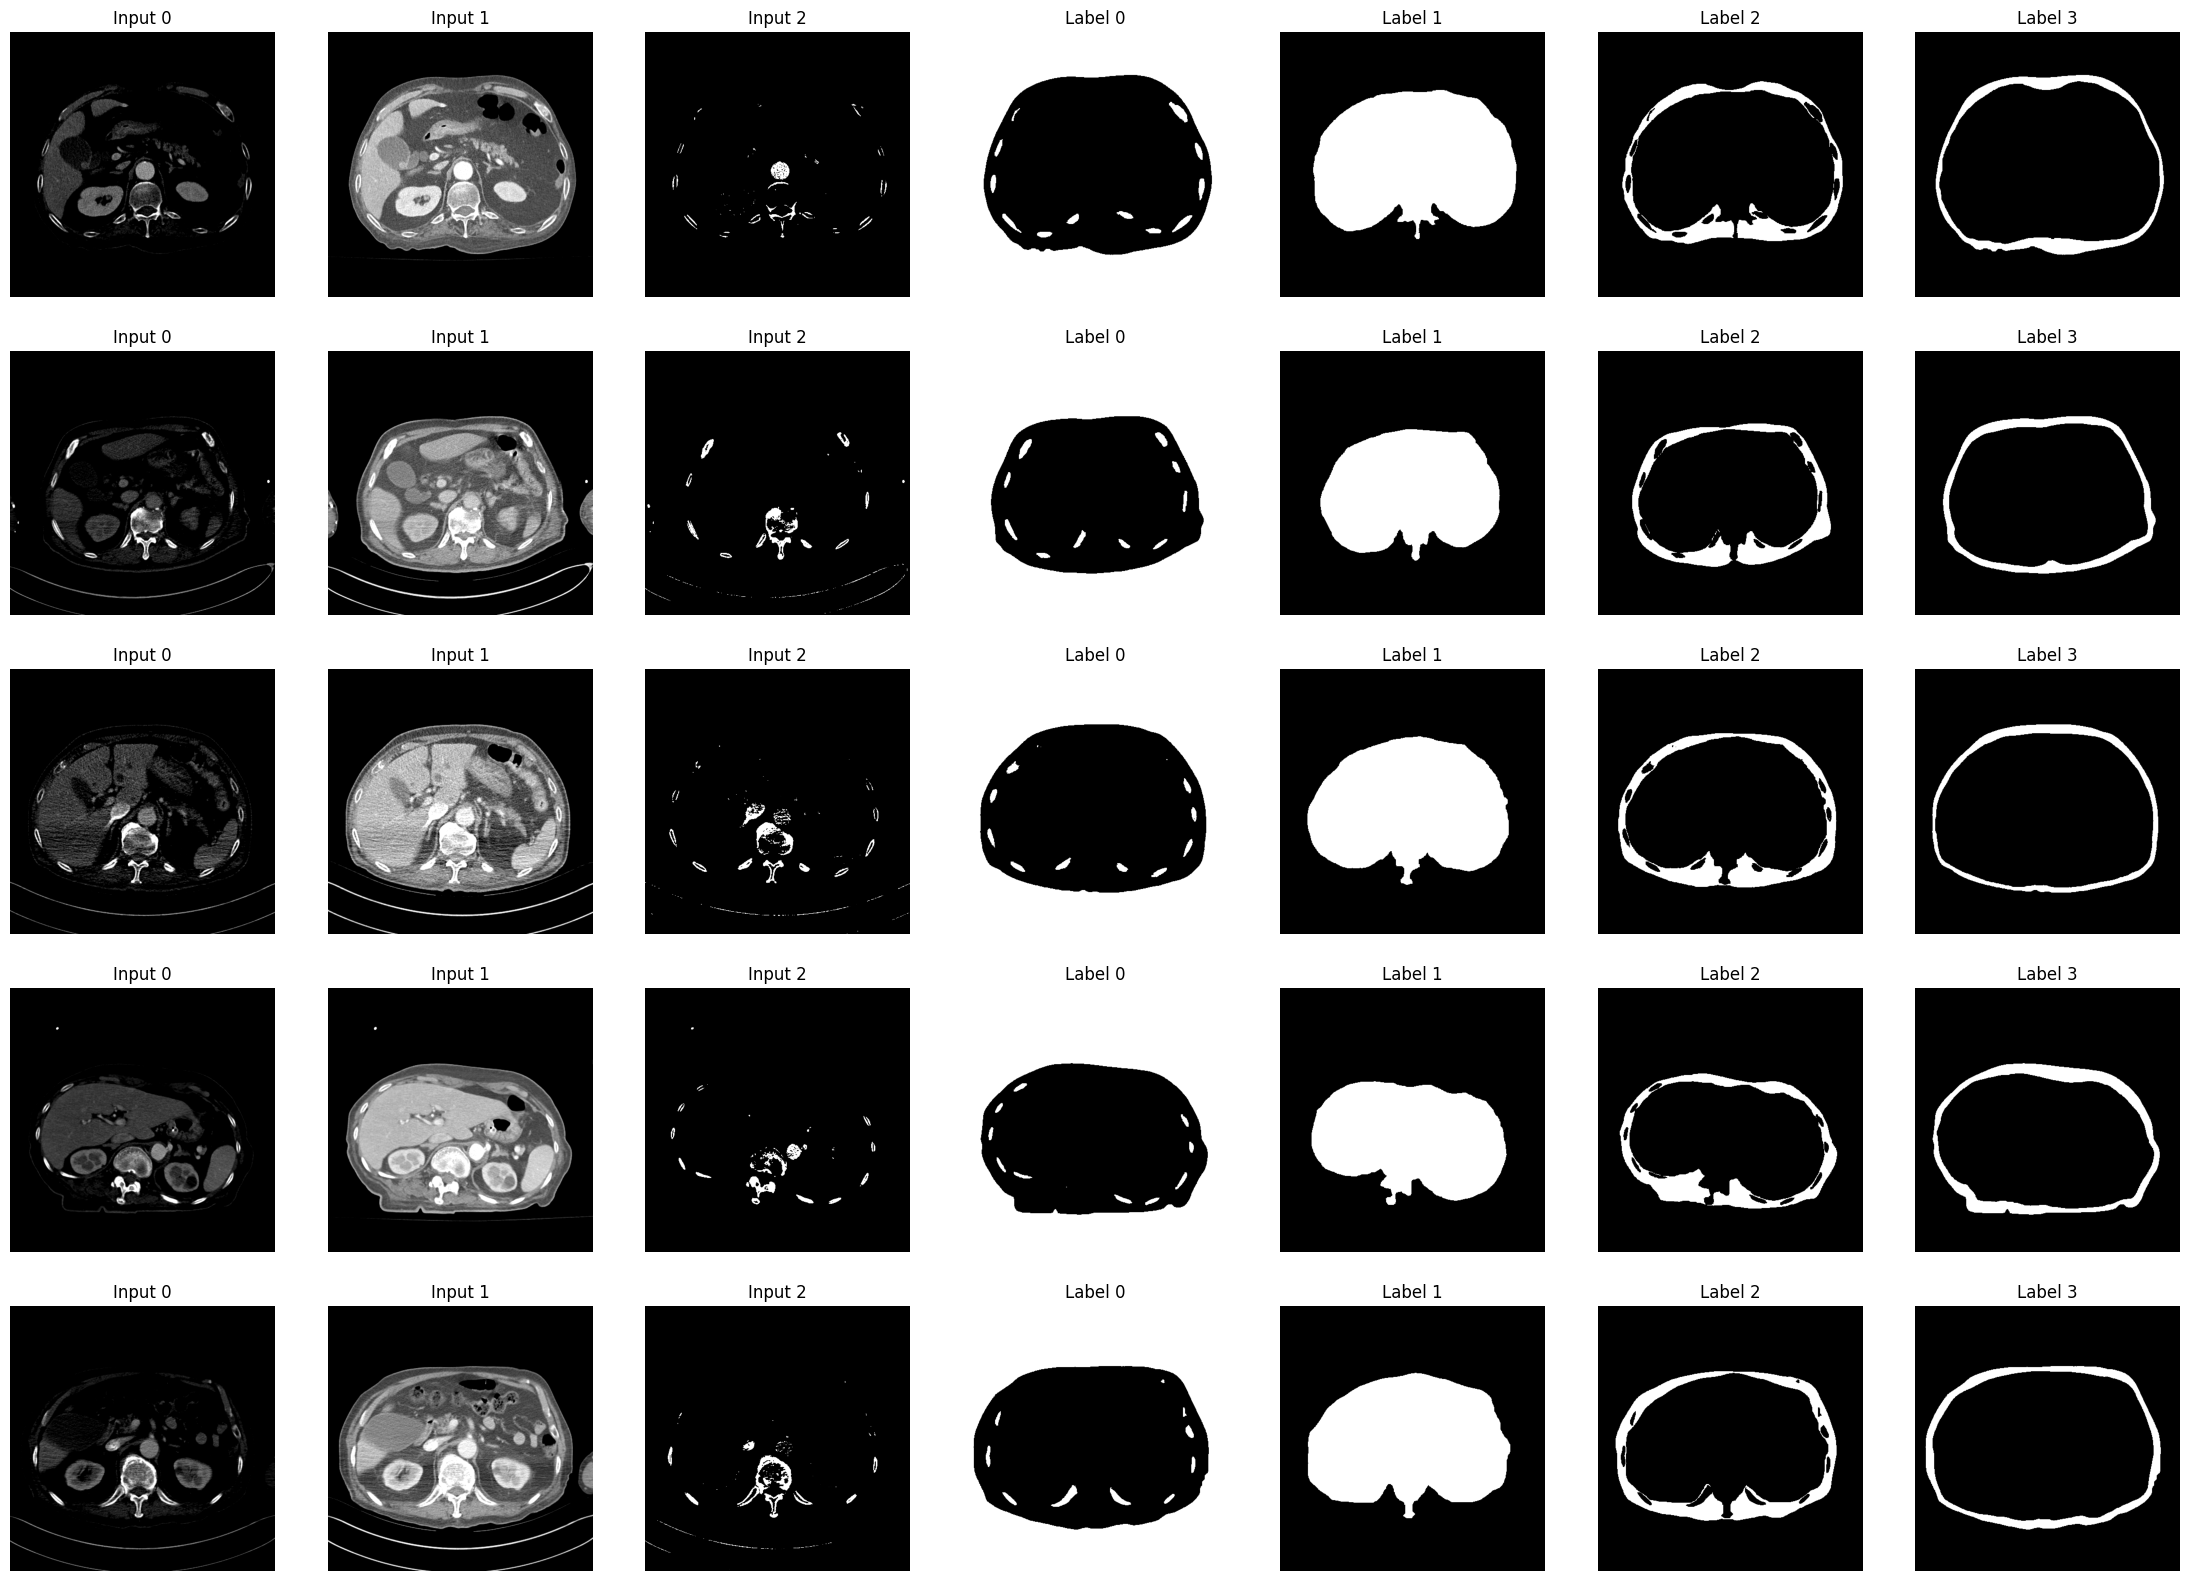

In [5]:
# Data Visualization
# Construct a figure on which we will visualize the images.
datalen = 5
datasize = 7
fig, axes = plt.subplots(datalen, datasize, figsize=(datasize*4, datalen*4))

# Plot each of the sequential images for one random data example.
data_choices = np.random.choice(range(len(inputs)), size=5)
num = 0
for idx, ax in enumerate(axes.flat):
    if (idx > 0) & (idx % 7 == 0) :
        num += 1
    data_choice = data_choices[num]

    if idx % 7 < 3 :
        ax.imshow(np.squeeze(inputs[data_choice][idx-num*7]), cmap="gray")
    else :
        ax.imshow(np.squeeze(outputs[data_choice][idx-num*7-3]), cmap="gray")
    
    if idx % 7 < 3 :
        title = f"Input {idx%7}"
    else :
        title = f"Label {idx%7-3}"
    ax.set_title(title)
    ax.axis("off")

# Print information and display the figure.
print(f"\nDisplaying frames for examples")
plt.show()

In [6]:
np.save('./inputs.npy', inputs)
np.save('./outputs.npy', outputs)

In [7]:
inputs.shape

(100, 3, 512, 512)

In [8]:
for i in range(3) :
    print(np.max(inputs[:, i]), np.min(inputs[:, i]))

1.0 0.0
1.0 0.0
1.0 0.0


In [10]:
outputs.shape

(100, 4, 512, 512)